### 1. some image utils

In [1]:
'''math tool'''
import csv
import numpy as np

'''plot tool'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker

'''image tool'''
import cv2
#import pyrealsense2 as rs
import statistics as sta

In [6]:
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber/109-2/210816_NTU_half/"
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
else:
    file_path = r"C:/Users/15sin/OneDrive/文件/GitHub/mapping_explorer/test data/"

In [7]:
npDepth = np.load(file_path+"depth.npy")
# pointCloud = np.load("/home/ncslaber/109-2/210824_calibration/pointCloud_6m.npy")
npColor = np.load(file_path+"color.npy")
npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.04) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)

In [ ]:
def depth_Z(u,v):
    return npDepth[v,u]
fx = 384.31365966796875
fy = 384.31365966796875
cx = 320.6562194824219
cy = 241.57083129882812

fxc = 616.811767578125
fyc = 616.7999267578125
cxc = 327.9185485839844
cyc = 241.32443237304688
depth_to_color_extrinsics = np.array( [[0.9999837279319763, -0.005083103198558092, -0.0025966160465031862],
                                        [0.005084178410470486, 0.999987006187439, 0.000407703424571082],
                                        [0.0025945098605006933, -0.000420898461015895, 0.999996542930603],
                                        [0.014714013785123825, 0.00010518113413127139, 0.0004244096053298563]] )
depth_to_color_extrinsics = depth_to_color_extrinsics.T

row, column = npDepth.shape

align_depth_to_color = np.zeros((row,column), dtype=np.uint16)

for v in range(row):
    for u in range(column):
        x_depth = (u-cx)/fx*depth_Z(u,v)
        y_depth = (v-cy)/fy*depth_Z(u,v)
        z_depth = depth_Z(u,v)

        world_depth = np.array([x_depth,y_depth,z_depth,1])
        world_depth = world_depth.T
        world_color = depth_to_color_extrinsics @ world_depth

        z_color = world_color[2]
        uc = world_color[0]/z_color*fxc+cxc
        vc = world_color[1]/z_color*fyc+cyc

        if (uc>=0 and uc<column ) and (vc>=0 and vc<row):
            align_depth_to_color[int(vc), int(uc)] = z_color
        else:
            # print("error: ", (uc,vc))
            pass

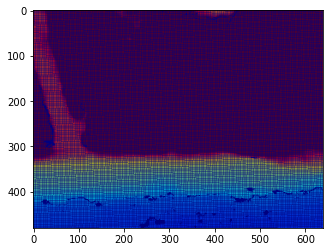

In [21]:
align_depth_to_color = cv2.convertScaleAbs(align_depth_to_color, alpha=0.04) # 6m
align_depth_to_color = cv2.applyColorMap(align_depth_to_color, cv2.COLORMAP_JET)
plt.imshow(cv2.cvtColor(align_depth_to_color, cv2.COLOR_BGR2RGB))

In [10]:
npColor.shape[::-1]

(3, 640, 480)

In [11]:
np.median(npDepth[479,:]) # ground L

745.0

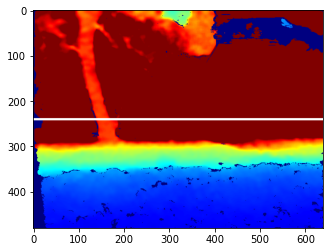

In [12]:
scan_height = 20
offset = int(npDepth.shape[0]/2-scan_height/2-scan_height*2)
cv2.line(npDepthF_color, (0, int(npDepth.shape[0]/2)), (npDepth.shape[1], int(npDepth.shape[0]/2)), (255, 255, 255), 3)
# cv2.line(npDepthF_color, (0, offset), (depth.shape[1], offset), (255, 255, 255), 3)
# cv2.line(npDepthF_color, (0, offset+scan_height), (depth.shape[1], offset+scan_height), (255, 255, 255), 3)
plt.imshow(cv2.cvtColor(npDepthF_color, cv2.COLOR_BGR2RGB))

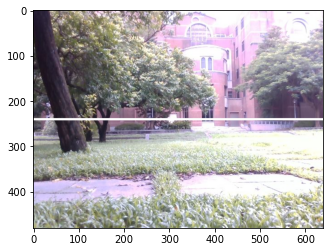

In [13]:
# cv2.line(color, (0, offset), (depth.shape[1], offset), (255, 255, 255), 3)
# cv2.line(color, (0, offset+scan_height), (depth.shape[1], offset+scan_height), (255, 255, 255), 3)
cv2.line(npColor, (0, int(npColor.shape[0]/2)), (npColor.shape[1], int(npColor.shape[0]/2)), (255, 255, 255), 3)
plt.imshow(npColor)

### 2. read .pgm

In [1]:
raw_pgm = cv2.imread("/home/ncslaber/hector_48_99.pgm")
raw_pgm = cv2.cvtColor(raw_pgm, cv2.COLOR_BGR2GRAY)
plt.imshow(raw_pgm, cmap='gray') #0,205,254

NameError: name 'cv2' is not defined

## 3. grid value process

In [25]:
gridValue = []
# file_path = "/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/analysis_map/height_middle.txt"
file_path = "/home/ncslaber/109-2/210818_NTU_libraryAll/ChiaY_innerArea/ChiaY_innerArea_gridValue_0818_full.txt"
with open(file_path, 'r') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    for row in rows:
        gridValue.append(row)
gridValue = np.asanyarray(gridValue)
gridValue = np.delete(gridValue, -1)
gridValue = gridValue.astype('float')
print("size of grid", gridValue.shape)
gridValue = np.reshape(gridValue,(2048,2048))
gridValue = np.flip(gridValue, 0)

(4194304,)


True

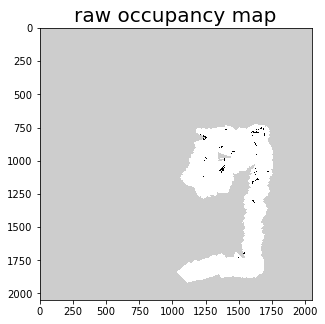

In [26]:
occupancy_map = np.copy(gridValue)
occupancy_map = occupancy_map.astype('float')
occupancy_map[gridValue>0] = 0
occupancy_map[gridValue<0] = 255
occupancy_map[gridValue==0] = 205
occupancy_map = np.reshape(occupancy_map,(2048,2048))
occupancy_map = occupancy_map.astype(dtype="uint8")
fig, ax = plt.subplots(figsize=(5,5))
# plt.axis('off')
plt.title('raw occupancy map',fontsize=20)
plt.imshow(cv2.cvtColor(occupancy_map, cv2.COLOR_GRAY2RGB))
# cv2.imshow("raw_pgm",cv2.cvtColor(occupancy_map, cv2.COLOR_GRAY2RGB))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
cv2.imwrite('/home/ncslaber/109-2/210818_NTU_libraryAll/ChiaY_innerArea/height_0.pgm',occupancy_map)

In [27]:
def draw_click_circle(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDBLCLK:
        print((x, y))
cv2.namedWindow('occupancy_map')
cv2.setMouseCallback('occupancy_map', draw_click_circle)
while True:
    # cv2.imshow('raw_pgm', cv2.resize(raw_pgm, (700, 700)))
    cv2.imshow('occupancy_map', occupancy_map)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        print("break click!")
        break
cv2.destroyAllWindows()

break click!


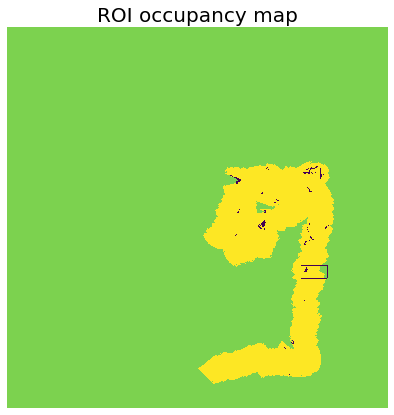

In [30]:
x1 = 750+530
y1 = 900+680
x2 = 750+600
y2 = 900+820
occupancy_map_rec = np.copy(occupancy_map)
cv2.rectangle(occupancy_map_rec,(y1,x1),(y2,x2),0,3)
fig, ax = plt.subplots(figsize=(7,7))
plt.axis('off')
plt.title('ROI occupancy map',fontsize=20)
plt.imshow(occupancy_map_rec)#cv2.cvtColor(occupancy_map_rec, cv2.COLOR_GRAY2RGB)

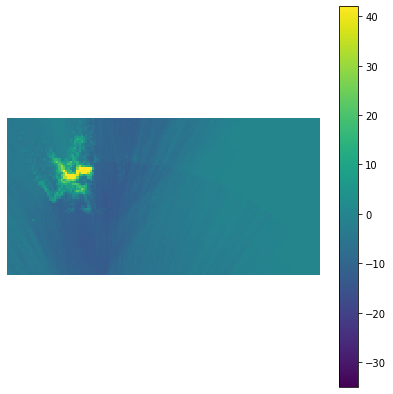

In [36]:
fig, axis = plt.subplots(figsize=(7, 7))
plt.axis('equal')
plt.imshow(gridValue[x1:x2,y1:y2], vmin=-35, vmax=42,)
plt.axis("off")
plt.colorbar()

(0, 10)

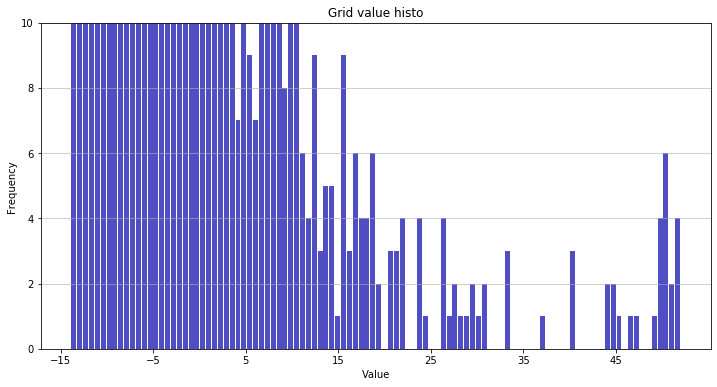

In [45]:
HOG = np.zeros(3000)
value_list = []
for i in range(x1,x2):
    for j in range(y1,y2):
        index = gridValue[i][j]
        value = int(index*10)/10
        value_list.append(value)
        index = int(index*10+1500)
        HOG[index] += 1
HOG_enum = list(enumerate(HOG, start=-1500))
HOG_enum = np.asarray(HOG_enum,dtype='float')
HOG_enum[:,0] /= 10

fig, axis = plt.subplots(figsize=(12, 6))
n, bins, patches = plt.hist(x=value_list, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Grid value histo')
axis.set_xticks(range(-15,50,10))

plt.ylim((0,10))
# plt.xlim((0,100))
# plt.scatter(HOG_enum[:,0], HOG_enum[:,1],label='a')

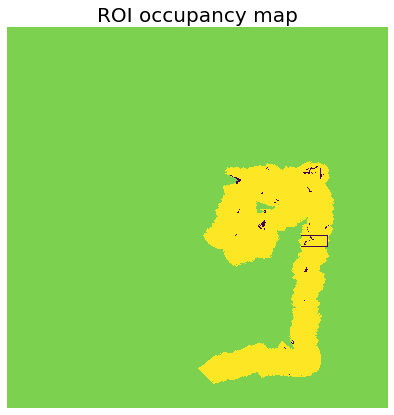

In [47]:
x1 = 750+370
y1 = 900+680
x2 = 750+430
y2 = 900+820
occupancy_map = np.ascontiguousarray(occupancy_map)
occupancy_map_rec = np.copy(occupancy_map)
cv2.rectangle(occupancy_map_rec,(y1,x1),(y2,x2),0,3)
fig, ax = plt.subplots(figsize=(7,7))
plt.axis('off')
plt.title('ROI occupancy map',fontsize=20)
plt.imshow(occupancy_map_rec)#cv2.cvtColor(occupancy_map_rec, cv2.COLOR_GRAY2RGB)

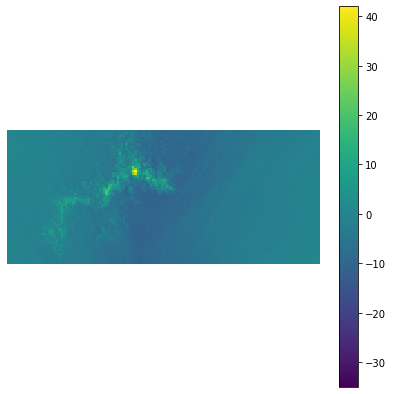

In [53]:
fig, axis = plt.subplots(figsize=(7, 7))
plt.axis('equal')
plt.imshow(gridValue[x1:x2,y1:y2], vmin=-35, vmax=42,)
plt.axis("off")
plt.colorbar()

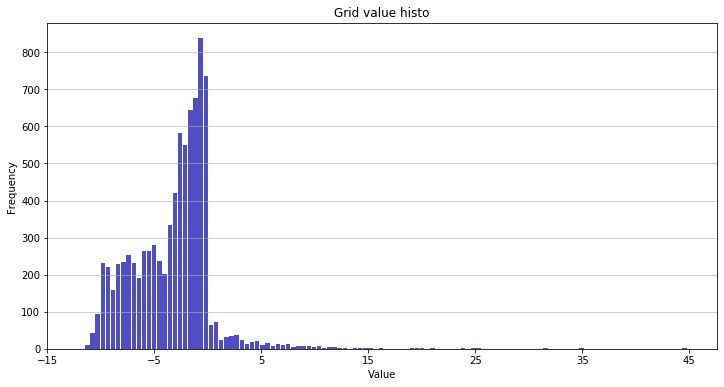

In [51]:
HOG = np.zeros(3000)
value_list = []
for i in range(x1,x2):
    for j in range(y1,y2):
        index = gridValue[i][j]
        value = int(index*10)/10
        value_list.append(value)
        index = int(index*10+1500)
        HOG[index] += 1
HOG_enum = list(enumerate(HOG, start=-1500))
HOG_enum = np.asarray(HOG_enum,dtype='float')
HOG_enum[:,0] /= 10

fig, axis = plt.subplots(figsize=(12, 6))
n, bins, patches = plt.hist(x=value_list, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Grid value histo')
axis.set_xticks(range(-15,50,10))

# plt.ylim((0,10))
# plt.xlim((0,100))
# plt.scatter(HOG_enum[:,0], HOG_enum[:,1],label='a')

(-0.5, 849.5, 1297.5, -0.5)

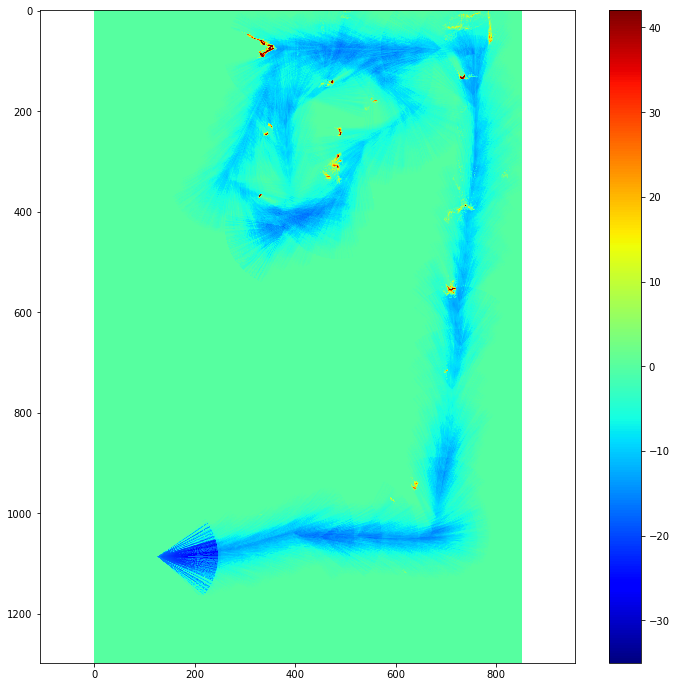

In [89]:
gridValue = np.reshape(gridValue,(1024*2,2*1024))
# gridValue = np.flip(gridValue, 0)
gridValue = np.ascontiguousarray(gridValue)
fig, axis = plt.subplots(figsize=(12, 12))
plt.imshow(gridValue[750:,900:1750],vmin=-35, vmax=42,cmap='jet', aspect='auto')
plt.colorbar()
plt.axis('equal')
# plt.axis("off")

(352842.6177075285, 352873.5195740558, 2767647.4340953534, 2767653.4488269235)

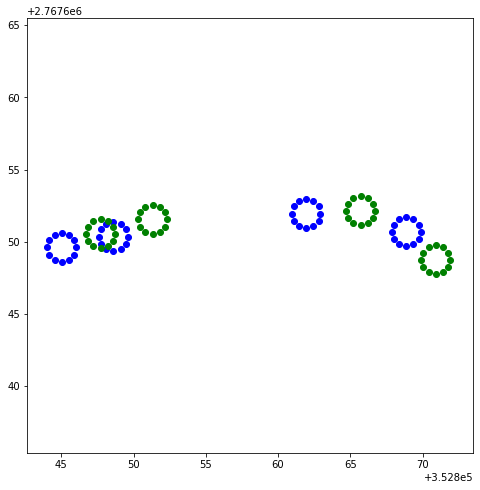

In [27]:
neg_bd_0818_x = []
neg_bd_0818_y = []
neg_bd_0725_x = []
neg_bd_0725_y = []
shp_path = '/home/ncslaber/109-2/210818_NTU_libraryAll/ChiaY_outerHalf_2021-08-17-17-17-10/shapefiles/'
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(4):
    neg_bd = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
    plt.scatter(neg_bd[:,0], neg_bd[:,1], c='b')
    neg_bd_0818_x.append(neg_bd[:,0])
    neg_bd_0818_y.append(neg_bd[:,1])
    
shp_path = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test3_2021-07-25-18-23-39/shapefiles/'
for i in range(4):
    neg_bd = np.load(shp_path+'neg_'+str(i+1)+'_bd_utm.npy')
    plt.scatter(neg_bd[:,0], neg_bd[:,1], c='g')
    neg_bd_0725_x.append(neg_bd[:,0])
    neg_bd_0725_y.append(neg_bd[:,1])
plt.axis('equal')

In [19]:
neg_bd_0818_x = np.asarray(neg_bd_0818_x)
neg_bd_0725_x = np.asarray(neg_bd_0725_x)
neg_bd_0818_y = np.asarray(neg_bd_0818_y)
neg_bd_0725_y = np.asarray(neg_bd_0725_y)
neg_bd_0818_x = neg_bd_0818_x.reshape((1,-2))
neg_bd_0818_y = neg_bd_0818_y.reshape((1,-2))
neg_bd_0725_x = neg_bd_0725_x.reshape((1,-2))
neg_bd_0725_y = neg_bd_0725_y.reshape((1,-2))

base = np.ones(48)
neg_bd_0818 = np.vstack((neg_bd_0818_x,neg_bd_0818_y,base))
neg_bd_0725 = np.vstack((neg_bd_0725_x,neg_bd_0725_y,base))
print(neg_bd_0725.shape)

(3, 48)


In [20]:
pinv = np.linalg.pinv(neg_bd_0818)
T1 = neg_bd_0725.dot(pinv)
neg_bd_0818_T = T1.dot(neg_bd_0818)

In [24]:
T1

array([[ 9.70570559e-01,  4.17630131e-01, -1.14546713e+06],
       [-1.35115161e-01,  1.36874816e+00, -9.72889766e+05],
       [-8.67361738e-19,  1.04083409e-17,  1.00000000e+00]])

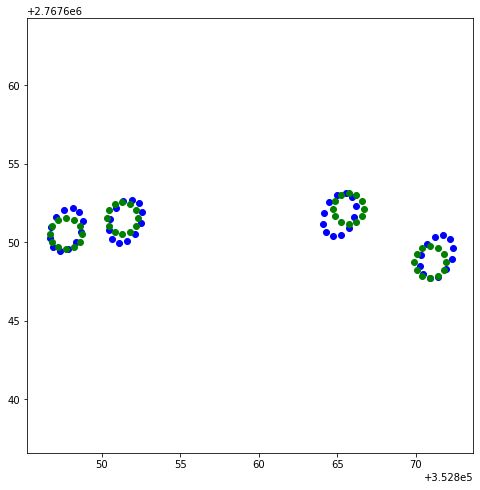

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.axis('equal')
plt.scatter(tmp[0], tmp[1], c='b')
plt.scatter(neg_bd_0725[0], neg_bd_0725[1], c='g')

### 4. find distance to trunk

in linux


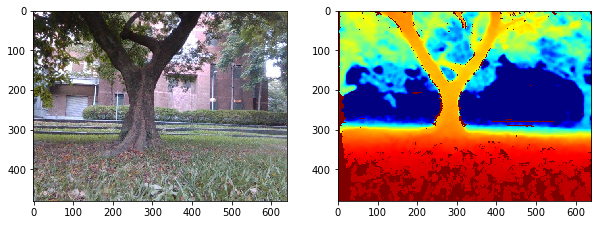

In [28]:
'''math tool'''
import csv
import numpy as np
from scipy.spatial import distance as dist

'''plot tool'''
import matplotlib.pyplot as plt

'''image tool'''
import cv2
import statistics as sta

import utm
from pyproj import Proj
import time
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber/realSense/catkin_ws/src/mapping_explorer/syn_rosbag/"

cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424

npDepth = np.load(file_path+"depth/circling.npy")
npColor = np.load(file_path+"color/circling.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

float16


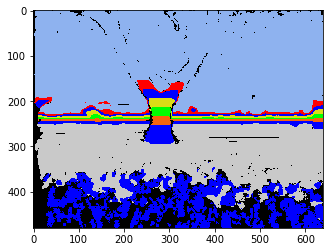

In [29]:
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<-50]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<300,npHeight>-50)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))


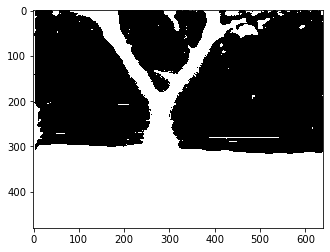

In [30]:
npDepth_binary = np.copy(npDepth)
npDepth_binary = npDepth_binary.astype('float32')

ret, npDepth_binary = cv2.threshold(npDepth_binary, 4800, 255, cv2.THRESH_BINARY_INV)
npDepth_binary = npDepth_binary.astype('uint8')

plt.imshow(cv2.cvtColor(npDepth_binary, cv2.COLOR_BGR2RGB))

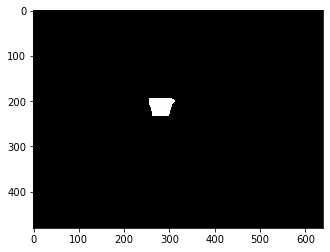

In [31]:
npHeight = npHeight.astype('float32')
ret, npDepth_binary1 = cv2.threshold(npHeight, 900, 255, cv2.THRESH_BINARY_INV)
ret, npDepth_binary2 = cv2.threshold(npHeight, 500, 255, cv2.THRESH_BINARY)


npMask_binary = cv2.bitwise_and(npDepth_binary1, npDepth_binary2)
npMask_binary = npMask_binary.astype('uint8')
npMask_binary = cv2.bitwise_and(npMask_binary, npDepth_binary)
plt.imshow(cv2.cvtColor(npMask_binary, cv2.COLOR_BGR2RGB))

In [32]:
staDistance = npDepth[npMask_binary.astype('bool')]
meanGrass = sta.mean(staDistance)
medianGrass = sta.median(staDistance)

meanGrass, medianGrass

(3901, 3891.0)